In [3]:
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import os.path
import matplotlib.pyplot as plt
import scipy.interpolate

In [4]:
def get_line_spacing(baselines):
    #print(baselines)
    center_x = np.median([(l.T[0][0] + l.T[0][-1])/2 for l in baselines])
    
    center_ys = []
    for line in baselines:
        xs, ys = line.T
        center_ys.append(np.interp(center_x, xs, ys))

    med_spacing = np.median(np.diff(center_ys))
    return int(round(med_spacing))

def box_from_baseline(baseline_points_str, med_spacing):
    lower_spacing = int(round(0.23 * med_spacing - 1))
    upper_spacing = int(round(0.77 * med_spacing - 1))
    
    baseline_points = np.array([p.split(",") for p in baseline_points_str.split(" ")], dtype=int)
    
    box_points = ""
    for i in range(len(baseline_points)):
        box_points += "{},{} ".format(baseline_points[i][0], baseline_points[i][1] + lower_spacing)
        
    for i in range(len(baseline_points)-1, -1, -1):
        box_points += "{},{} ".format(baseline_points[i][0], max(0, baseline_points[i][1] - upper_spacing))

    return box_points[:-1] #trim whitespace

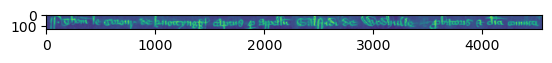

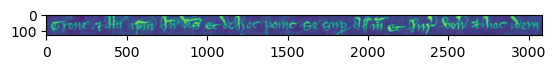

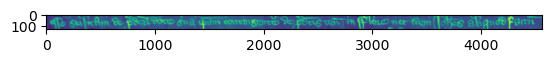

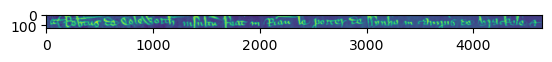

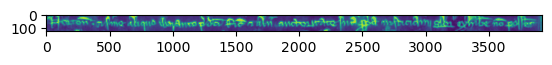

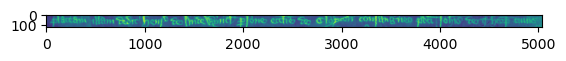

In [7]:
def subtract_bkd(image):
    bkd = np.percentile(image, 80, axis=0)
    cols = np.arange(image.shape[1])
    coeffs = np.polyfit(cols, bkd, 2)
    smoothed_bkd = np.polyval(coeffs, cols)
    new_image = np.copy(image) / smoothed_bkd * np.median(smoothed_bkd)
    return new_image

def extract_line_image(image_filename, output_filename, baseline, spacing, scaled_height=128, pad=10):
    baseline = np.unique(baseline, axis=0) #remove repeat points
    lower_spacing = int(round(0.23 * spacing - 1))
    upper_spacing = int(round(0.77 * spacing - 2))
    height = lower_spacing + upper_spacing
    
    image = cv2.imread(image_filename, 0)
    xs, ys = baseline.T
    dense_xs = np.arange(max(0, xs.min() - pad), 
                         min(image.shape[1]-1, xs.max() + pad))
    
    rectified = np.zeros((height, len(dense_xs)))
    dense_ys = scipy.interpolate.interp1d(xs, ys, bounds_error=False, kind="linear", fill_value="extrapolate")(dense_xs)
    #print(dense_xs.dtype, image.dtype)
    
    for i,x in enumerate(dense_xs):
        y_min = max(0, int(round(dense_ys[i] - upper_spacing)))
        y_max = min(image.shape[0] - 1, y_min + height)
        rectified[0:y_max-y_min,i] = image[y_min:y_max, x]

    scaled_width = int(round(scaled_height / height * rectified.shape[1]))
    rectified = subtract_bkd(rectified)
    result = cv2.resize(rectified, (scaled_width, scaled_height), cv2.INTER_CUBIC)
    result = (np.median(result) - result) / (np.percentile(result, 90) - np.percentile(result, 10))
    
    cv2.imwrite(output_filename, 255 * (result - result.min()) / (result.max() - result.min()))
        
    if np.random.randint(100) == 0:
        plt.figure()
        plt.imshow(result)
    np.save(output_filename.replace(".png", ".npy"), result)

for filename in glob.glob("*.xml"):
    baselines = []
    ns = {'ns': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
    ET.register_namespace('', ns['ns'])

    tree = ET.parse(filename)
    root = tree.getroot()

    image_filename = root.find('ns:Page', ns).get('imageFilename')
    
    #First iteration: calculate average line spacing
    for text_region in root.findall('.//ns:TextRegion', ns):
        for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):
            baseline = text_line.find('ns:Baseline', ns).get('points')
            baselines.append(np.array([p.split(",") for p in baseline.split(" ")], dtype=int))
        
    med_spacing = get_line_spacing(baselines)

    #Second iteration: update bounding boxes
    for text_region in root.findall('.//ns:TextRegion', ns):
        for lineno, text_line in enumerate(text_region.findall('.//ns:TextLine', ns)):
            baseline = text_line.find('ns:Baseline', ns).get('points')          
            line_im_filename = "line_{}_{}".format(lineno, image_filename)
            line_im_filename, _ = os.path.splitext(line_im_filename)
            line_im_filename += ".png"
            extract_line_image(image_filename, line_im_filename, baselines[lineno], med_spacing)
            
            updated_box_text = box_from_baseline(baseline, med_spacing)
            box = text_line.find('ns:Coords', ns)
            box.set('points', updated_box_text)

    tree.write('modified/' + filename)

In [8]:
test = np.load("line_0_0025_JUST1-635m36d.npy")
%matplotlib qt
plt.figure(figsize=(16,6))
plt.imshow(test, cmap="gray")
plt.figure()
plt.hist(test.flatten())

libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


(array([7.76000e+02, 2.18581e+05, 1.95908e+05, 5.19030e+04, 4.27430e+04,
        4.79260e+04, 6.14300e+04, 3.84990e+04, 4.47100e+03, 1.63000e+02]),
 array([-0.4676745 , -0.26658292, -0.06549134,  0.13560024,  0.33669182,
         0.5377834 ,  0.73887498,  0.93996656,  1.14105815,  1.34214973,
         1.54324131]),
 <BarContainer object of 10 artists>)

In [17]:
center_ys = []
for line in baselines:
    xs, ys = line.T
    #print(ys)
    center_ys.append(np.interp(512, xs, ys))
#plt.plot(np.diff(center_ys))
print(np.median(np.diff(center_ys)))

34.4723462727585


In [33]:
[(l.T[0][0] + l.T[0][-1])/2 for l in baselines]

[488.0,
 465.5,
 494.0,
 501.5,
 506.0,
 507.5,
 220.0,
 496.0,
 501.0,
 501.5,
 502.0,
 499.0,
 505.0,
 85.5]

In [25]:
baselines[0].T[0]

array([  8, 278, 446, 566, 810, 968])

In [48]:
print(baselines[0])

[[  8  61]
 [278  45]
 [446  35]
 [566  35]
 [810  28]
 [968  29]]
